# Setup

In [1]:
from pathlib import Path
import warnings

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    StratifiedKFold,
    train_test_split,
)
from sklearn.ensemble import RandomForestClassifier

import umap

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PROJ_ROOT = Path().resolve().parent

### Starting Data

In [3]:
df_neoag = pd.read_feather(PROJ_ROOT / "data" / "neoantigens.arrow")
df_surv = pd.read_feather(PROJ_ROOT / "data" / "survival.arrow")

I've already done some basic preprocessing (See `src/00-preprocess.py`). Time to try overfitting by doing everything wrong!

First, here's what the cleaned up data looks like. I'm making use of pandas [`MultiIndex`](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) for the first time. Seems like it could prove quite nice and usefull. 

In [4]:
df_neoag

MUTATION_ID WT.Peptide MT.Peptide MT.Allele  \
Dataset  Sample                                                           
VanAllen Pat02      1_1563747_C_T_Pat02  NHREVAQIL  NYREVAQIL     C0702   
         Pat02     1_17087582_G_A_Pat02  SPSNDFQVL  SPLNDFQVL     B0801   
         Pat02     1_17087582_G_A_Pat02  SPSNDFQVL  SPLNDFQVL     B0702   
         Pat02     1_21806573_A_G_Pat02  LLDEKEPEV  LLDEKGPEV     A0201   
         Pat02     1_46073697_C_T_Pat02  KPGQEAPVL  KPGQEASVL     B0702   
...                                 ...        ...        ...       ...   
Rizvi    ZA6965  8_113697930_C_A_ZA6965  CLSNFTAPM  CLSNFTAPI     A3201   
         ZA6965   X_68749680_T_A_ZA6965  RLCVLVLML  RLSVLVLML     A0201   
         ZA6965   X_68749680_T_A_ZA6965  RLCVLVLML  RLSVLVLML     A3201   
         ZA6965   X_68749680_T_A_ZA6965  SRIRLCVLV  SRIRLSVLV     C0602   
         ZA6965   X_68749680_T_A_ZA6965  IRLCVLVLM  IRLSVLVLM     C0602   

                 WT.Score  MT.Score  \
Dataset  Sample                       
VanAllen Pat02        701        70   
         Pat02        739       202   
         Pat02         32        37   
         Pat02          8         9   
         Pat02         90        31   
...                   ...       ...   
Rizvi    ZA6965      1850        71   
         ZA6965       419       172   
         ZA6965       516       314   
         ZA6965       751       146   
         ZA6965      2682       279   

                                                           HLA  
Dataset  Sample                                                 
VanAllen Pat02             A0201,A2601,B0801,B0702,C0702,C0702  
         Pat02             A0201,A2601,B0801,B0702,C0702,C0702  
         Pat02             A0201,A2601,B0801,B0702,C0702,C0702  
         Pat02             A0201,A2601,B0801,B0702,C0702,C0702  
         Pat02             A0201,A2601,B0801,B0702,C0702,C0702  
...                                                        ...  
Rizvi    ZA6965  A0201,A3201,A0289,B400102,B450101,C0602,C0304  
         ZA6965  A0201,A3201,A0289,B400102,B450101,C0602,C0304  
         ZA6965  A0201,A3201,A0289,B400102,B450101,C0602,C0304  
         ZA6965  A0201,A3201,A0289,B400102,B450101,C0602,C0304  
         ZA6965  A0201,A3201,A0289,B400102,B450101,C0602,C0304  

[70437 rows x 7 columns]

In [5]:
df_surv

Months  Status
Dataset  Sample                   
VanAllen Pat02   53.654736   False
         Pat03    3.287668    True
         Pat04   32.449280   False
         Pat06    5.293145    True
         Pat08    4.602735    True
...                    ...     ...
Rizvi    GR0134  21.900000   False
         VA1330  23.400000    True
         NI9507  27.900000   False
         AU5884   2.400000    True
         VA7859  16.100000   False

[201 rows x 2 columns]

Checking that all of the indices, {(dataset_name, sample_name)}, in the neoantigen dataset are also in the survival data (and vice versa): 

In [6]:
set(df_neoag.index) - set(df_surv.index)

{('VanAllen', 'Pat07'),
 ('VanAllen', 'Pat105'),
 ('VanAllen', 'Pat57'),
 ('VanAllen', 'Pat58'),
 ('VanAllen', 'Pat63'),
 ('VanAllen', 'Pat66'),
 ('VanAllen', 'Pat77')}

In [7]:
set(df_surv.index) - set(df_neoag.index)

{('Rizvi', 'VA1330'), ('Rizvi', 'VA7859'), ('Snyder', 'NR8727')}

Hmmmm, seems some indexes aren't lining up. Not going to look more into it now, but it might be within the scope of our assignment if these samples were selectively removed during the orig author's QC. What's the damage in terms of lost neoantigen records?

In [8]:
df_inmerge = pd.merge(
    df_neoag, df_surv, left_index=True, right_index=True, validate="m:1", how="inner"
)

print(f"Lost NeoAg records: {len(df_neoag) - len(df_inmerge)} / {len(df_neoag)}")

Lost NeoAg records: 2709 / 70437


-----------------------------------

#### Survival Curves by Dataset

Moving on for now, let's try a basic survival analysis per dataset. 

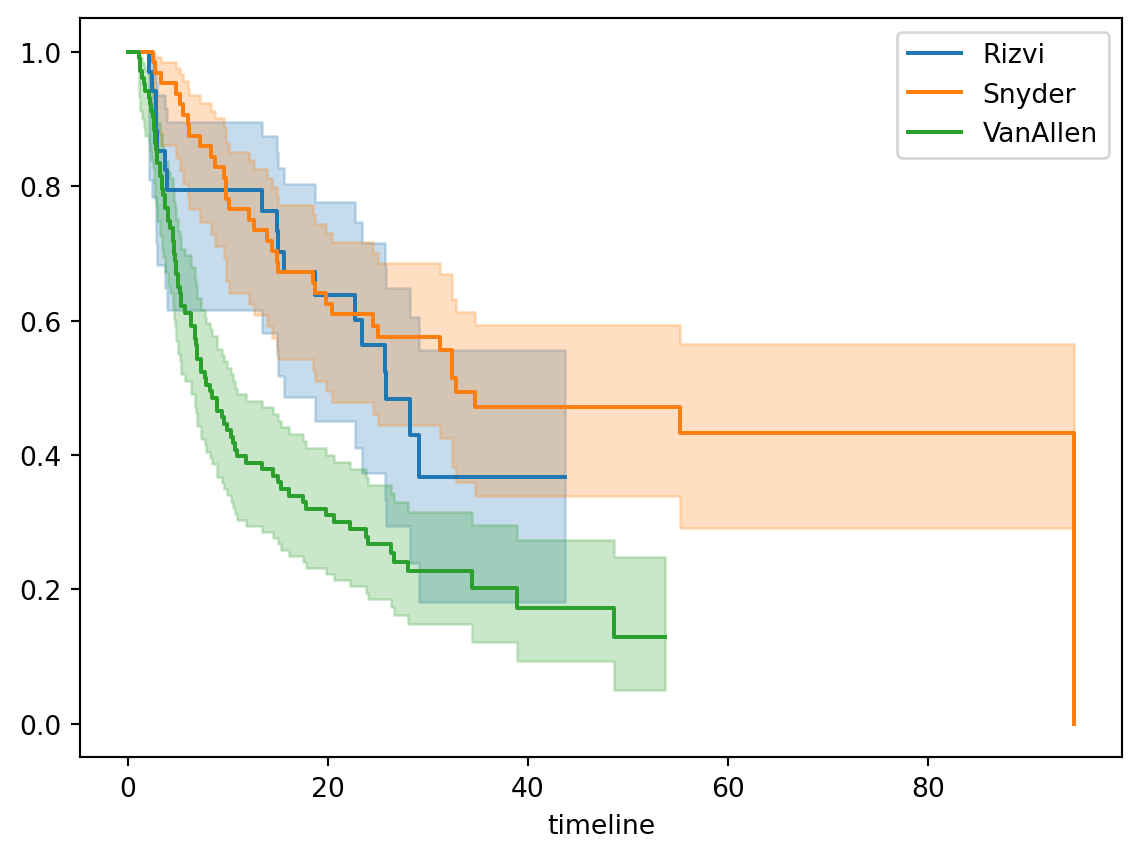

In [9]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in df_surv.groupby("Dataset"):
    kmf.fit(grouped_df["Months"], grouped_df["Status"], label=name)
    kmf.plot_survival_function(
        ax=ax,
    )

Quite a difference between the datasets... our goal is to overfit, this could be a good source of bias. 
 - The Snyder paper had a different selection criteria than the other studies, which manifests here. They chose to only include good responders in their final dataset.

--------------------------------------

But for now, I'll keep all of the datasets lumped together. I want to try exploding the feature set, and then use non-linear dimension reduction to 'find' some structure. I'll simply create a new column for each unique 9-mer observed, in addition to each HLA type. This will be very sparse. 
 - See a small example of this feature transformation at: `./featurization_reprex.ipynb`.

### Featurization

In [10]:
# hla types have some typos in them, quick and dirty fix
def parse_hla_str(hla_str):
    return [i for i in "".join(hla_str.split()).split(",") if len(i) > 0]


# a mess
parse_hla_str(",  a,,b  b, cd ,   ,")

['a', 'bb', 'cd']

In [11]:
hla = df_inmerge[["HLA"]].drop_duplicates()
hla["HLA"] = hla["HLA"].map(parse_hla_str)
hla_idx = hla.index

mlb = MultiLabelBinarizer(sparse_output=True)
hla = mlb.fit_transform(hla.HLA)

hla_labs = ["hla_" + i for i in mlb.classes_]
# putting into sparse dataframe for easier index-based rejoining
hla = pd.DataFrame.sparse.from_spmatrix(hla, index=hla_idx, columns=hla_labs)

In [12]:
pep = (
    df_inmerge[["MT.Peptide"]]
    .groupby(["Dataset", "Sample"])
    .agg({"MT.Peptide": lambda x: list(x)})
)
pep_idx = pep.index

mlb = MultiLabelBinarizer(sparse_output=True)
pep = mlb.fit_transform(pep["MT.Peptide"])

pep_labs = ["mtpep_" + i for i in mlb.classes_]
pep = pd.DataFrame.sparse.from_spmatrix(pep, index=pep_idx, columns=pep_labs)

In [13]:
df_sparse_hp = hla.join(pep)
del (pep, hla)

df_sparse_hp

hla_A  hla_A0101  hla_A0104  hla_A0201  hla_A0204  hla_A0206  \
Dataset  Sample                                                                 
Rizvi    AL4602      0          0          0          0          0          0   
         AU5884      0          0          0          1          0          0   
         BL3403      0          0          0          1          0          0   
         CA9903      0          0          0          1          0          0   
         CU9061      0          1          0          0          0          0   
...                ...        ...        ...        ...        ...        ...   
VanAllen Pat86       0          0          0          0          0          0   
         Pat88       0          0          0          0          0          0   
         Pat90       0          0          0          0          0          0   
         Pat92       0          1          0          0          0          0   
         Pat98       0          1          0          0          0          0   

                 hla_A0214  hla_A0289  hla_A0301  hla_A0321  ...  \
Dataset  Sample                                              ...   
Rizvi    AL4602          0          0          1          0  ...   
         AU5884          0          0          0          0  ...   
         BL3403          0          0          0          0  ...   
         CA9903          0          0          0          0  ...   
         CU9061          0          0          0          0  ...   
...                    ...        ...        ...        ...  ...   
VanAllen Pat86           0          0          0          0  ...   
         Pat88           0          0          1          0  ...   
         Pat90           0          0          0          0  ...   
         Pat92           0          0          1          0  ...   
         Pat98           0          0          1          0  ...   

                 mtpep_YYYFLRPLL  mtpep_YYYIKLKDL  mtpep_YYYLNTPRV  \
Dataset  Sample                                                      
Rizvi    AL4602                0                0                0   
         AU5884                0                0                0   
         BL3403                0                0                0   
         CA9903                0                0                0   
         CU9061                0                0                0   
...                          ...              ...              ...   
VanAllen Pat86                 0                0                0   
         Pat88                 0                0                0   
         Pat90                 0                0                0   
         Pat92                 0                0                0   
         Pat98                 0                0                0   

                 mtpep_YYYPYTYST  mtpep_YYYQGNWCV  mtpep_YYYQSRGRL  \
Dataset  Sample                                                      
Rizvi    AL4602                0                0                0   
         AU5884                0                0                0   
         BL3403                0                0                0   
         CA9903                0                0                0   
         CU9061                0                0                0   
...                          ...              ...              ...   
VanAllen Pat86                 0                0                0   
         Pat88                 0                0                0   
         Pat90                 0                0                0   
         Pat92                 0                0                0   
         Pat98                 0                0                0   

                 mtpep_YYYRHTRSI  mtpep_YYYSNTPRV  mtpep_YYYTGPKTL  \
Dataset  Sample                                                      
Rizvi    AL4602                0                0                0   
         AU5884                0              

# Goal / Strategy

That's a sparse feature space alright. I'm now setup for my general goal: combine leakage (from pre-processing) and poor technique to generate noise with just enough signal to overfit on. Hopefully this represents the type of analysis where one slowly goes down the rabbit hole, trying and combining many methods without fully understanding underlying assumptions of limitations. That, plus a little leakage, could lead to falsely optimistic model evaluation that is obfuscated by lots of complex steps chained together. 

I've also kept my code well organized. Anyone who uses Make/Snakemake in an analysis probably knows what they're doing, right? It looks robust and therefore is robust!

I'll start with dimensionality reduction. I'll follow the 'typical' UMAP pipeline from [its FAQ](https://umap-learn.readthedocs.io/en/latest/faq.html): 
>  \[start with a] high-dimensional embedding (300+) => PCA to reduce to 50 dimensions => UMAP to reduce to 10-20 dimensions => HDBSCAN for clustering / some plain algorithm for classification

PCA probably isn't the best option for binary data, whatever... probs fine ¯\_(ツ)_/¯

I still need to decide how I'll actually classify samples. A bad (and therefore good) approach might be: 
1. Use `lifelines` to fit a survival regression on the un-split, reduced dim, data.
2. Predict survival times for censored samples
3. Define a cutoff of "good prognosis" as survival times above some upper percentile
4. Train an overly complex model to predict the resulting binary prognosis

--------------------------------------

## PCA + UMAP

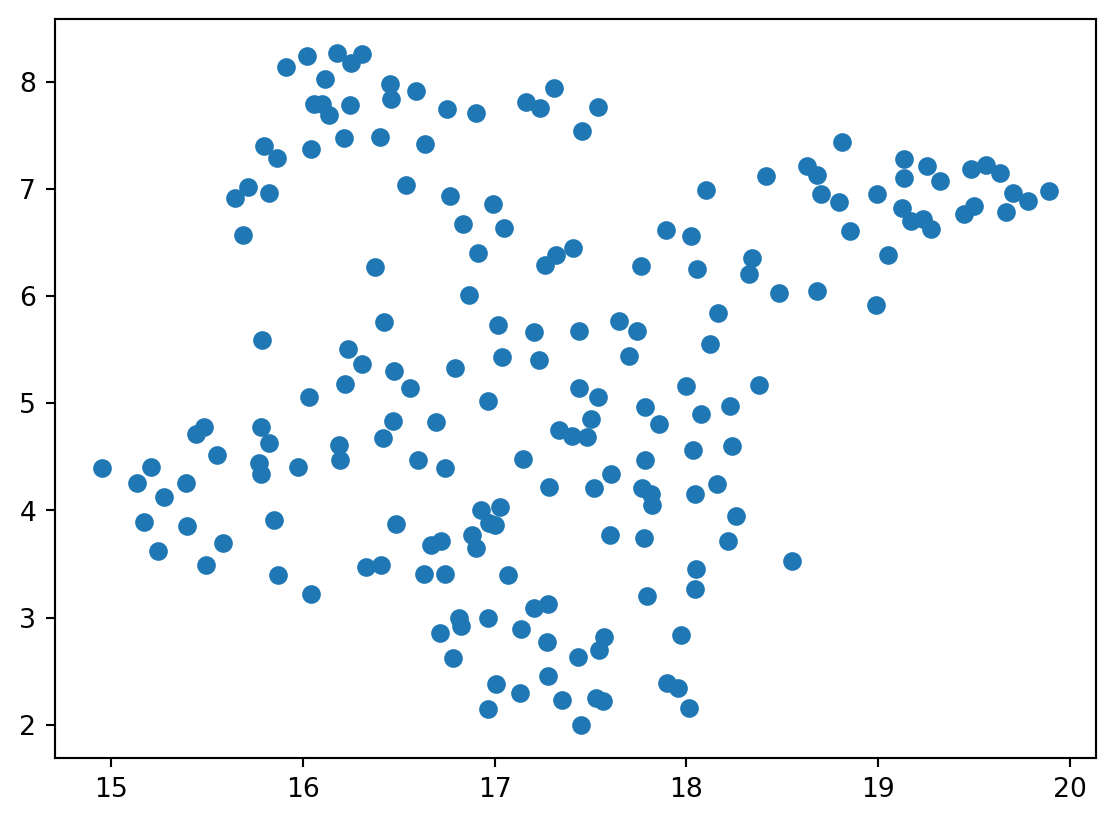

In [14]:
seed = 123654

pca = PCA(n_components=50, random_state=seed)
X = pca.fit_transform(df_sparse_hp.sparse.to_dense())

reducer = umap.UMAP(n_components=2, random_state=seed)

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    # ignore random state parallelism warning
    reducer.fit(X)

emb_2d = reducer.transform(X)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1])

Wow, pretty. Looks like a dogwood flower. 

![Wikipedia, Dogwood](https://upload.wikimedia.org/wikipedia/commons/7/71/Blooming_Dogwood.jpg)
Time for survival regression on a slightly larger embedding. 

In [15]:
reducer = umap.UMAP(n_components=15, random_state=seed)

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    # ignore random state parallelism warning
    reducer.fit(X)

emb = reducer.transform(X)

In [16]:
emb = pd.DataFrame(emb, columns=["emb_" + str(i) for i in range(15)])

emb.index = df_sparse_hp.index

emb = emb.join(df_surv)

emb

emb_0      emb_1     emb_2     emb_3     emb_4     emb_5  \
Dataset  Sample                                                                
Rizvi    AL4602  8.696940  11.990170  0.422310  5.676660  1.730538  7.818952   
         AU5884  8.752948  12.221260  0.473912  6.023926  1.606221  6.383737   
         BL3403  9.147636  12.269960  1.013504  5.765378  0.930015  6.482364   
         CA9903  9.291765  11.479907  0.754091  5.993539  1.738141  7.856709   
         CU9061  9.978414  11.595785  1.104702  6.006626  1.051059  6.573788   
...                   ...        ...       ...       ...       ...       ...   
VanAllen Pat86   9.714375  11.590719  1.222511  5.510706  1.193158  6.025036   
         Pat88   9.316399  11.742634  1.016974  5.539266  1.715220  6.095654   
         Pat90   9.520435  11.297050  0.857334  5.837837  1.803043  6.680264   
         Pat92   9.697490  11.941105  1.344234  5.327190  0.681422  6.216207   
         Pat98   9.595166  10.845682  0.724423  6.057424  1.974941  8.719937   

                    emb_6     emb_7     emb_8     emb_9    emb_10    emb_11  \
Dataset  Sample                                                               
Rizvi    AL4602  6.427540 -0.394721  4.523087  0.513556  0.801915  7.228773   
         AU5884  7.280601 -0.566004  4.286410  0.384666  0.680064  7.436167   
         BL3403  7.538159 -0.831413  4.473774  0.490223  0.304591  7.705140   
         CA9903  6.444182  0.105935  4.283933  1.084071  0.725128  6.995952   
         CU9061  7.405111 -0.340879  3.802712  0.777255  0.701506  7.209377   
...                   ...       ...       ...       ...       ...       ...   
VanAllen Pat86   7.456265 -1.113912  4.262743  0.107270  0.516630  7.824129   
         Pat88   7.034050 -0.741824  4.312298  0.259437  1.131083  7.789999   
         Pat90   6.881317 -0.458146  4.089032  0.446105  0.878745  7.351237   
         Pat92   7.430692 -1.214920  4.330660  0.134567  0.496735  7.918049   
         Pat98   5.842069  0.547050  4.083318  1.388299  1.212203  6.688455   

                   emb_12    emb_13    emb_14     Months  Status  
Dataset  Sample                                                   
Rizvi    AL4602  4.391820  4.124061  2.389610  25.600000   False  
         AU5884  4.848963  4.543642  2.887088   2.400000    True  
         BL3403  4.851251  4.020684  3.105686  13.400000    True  
         CA9903  4.229937  4.021850  2.296034  34.299999   False  
         CU9061  4.547236  3.443910  2.755784  15.600000    True  
...                   ...       ...       ...        ...     ...  
VanAllen Pat86   4.611051  3.808496  2.713874   9.632866    True  
         Pat88   4.442368  4.018101  2.503051  32.515034   False  
         Pat90   4.319640  4.094122  2.312619  33.041061   False  
         Pat92   4.690978  3.341409  2.785475   4.043831    True  
         Pat98   3.650345  3.539864  1.691715   4.602735    True  

[195 rows x 17 columns]

## Survial Regression

For the sake of predicting median survival time in censored subjects. 

In [17]:
cph = CoxPHFitter()
cph.fit(emb, duration_col="Months", event_col="Status")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 195 total observations, 66 right-censored observations>
             duration col = 'Months'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 195
number of events observed = 129
   partial log-likelihood = -597.78
         time fit was run = 2023-12-04 17:39:42 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
emb_0      -0.92       0.40       3.09            -6.98             5.14                 0.00               171.19
emb_1      -3.80       0.02       3.34           -10.36             2.75                 0.00                15.63
emb_2       2.11       8.26       4.14            -6.01            10.23                 0.00             27793.87
emb_3       4.10      60.53       6.79            -9.20            17.41                 0.00             3.64e+07
emb_4      -5.13       0.01       4.37           -13.69             3.43                 0.00                30.87
emb_5       1.56       4.75       1.90            -2.16             5.27                 0.12               195.39
emb_6      -2.47       0.08       5.14           -12.54             7.59                 0.00              1987.65
emb_7       1.12       3.07       4.60            -7.90            10.14                 0.00             25398.30
emb_8       1.56       4.74       4.15            -6.58             9.69                 0.00             16150.52
emb_9      -4.11       0.02       5.43           -14.75             6.53                 0.00               687.12
emb_10      5.08     161.25       3.67            -2.12            12.29                 0.12             2.17e+05
emb_11      1.27       3.57       4.20            -6.96             9.50                 0.00             13384.82
emb_12      4.67     107.04       4.07            -3.30            12.64                 0.04             3.10e+05
emb_13      1.52       4.55       4.77            -7.83            10.86                 0.00             52225.16
emb_14      2.00       7.40       5.60            -8.97            12.97                 0.00             4.31e+05

            cmp to     z    p   -log2(p)
covariate                               
emb_0         0.00 -0.30 0.77       0.38
emb_1         0.00 -1.14 0.26       1.97
emb_2         0.00  0.51 0.61       0.71
emb_3         0.00  0.60 0.55       0.87
emb_4         0.00 -1.17 0.24       2.06
emb_5         0.00  0.82 0.41       1.28
emb_6         0.00 -0.48 0.63       0.67
emb_7         0.00  0.24 0.81       0.31
emb_8         0.00  0.37 0.71       0.50
emb_9         0.00 -0.76 0.45       1.16
emb_10        0.00  1.38 0.17       2.59
emb_11        0.00  0.30 0.76       0.39
emb_12        0.00  1.15 0.25       2.00
emb_13        0.00  0.32 0.75       0.41
emb_14        0.00  0.36 0.72       0.47
---
Concordance = 0.58
Partial AIC = 1225.56
log-likelihood ratio test = 19.83 on 15 df
-log2(p) of ll-ratio test = 2.48

<Axes: xlabel='log(HR) (95% CI)'>

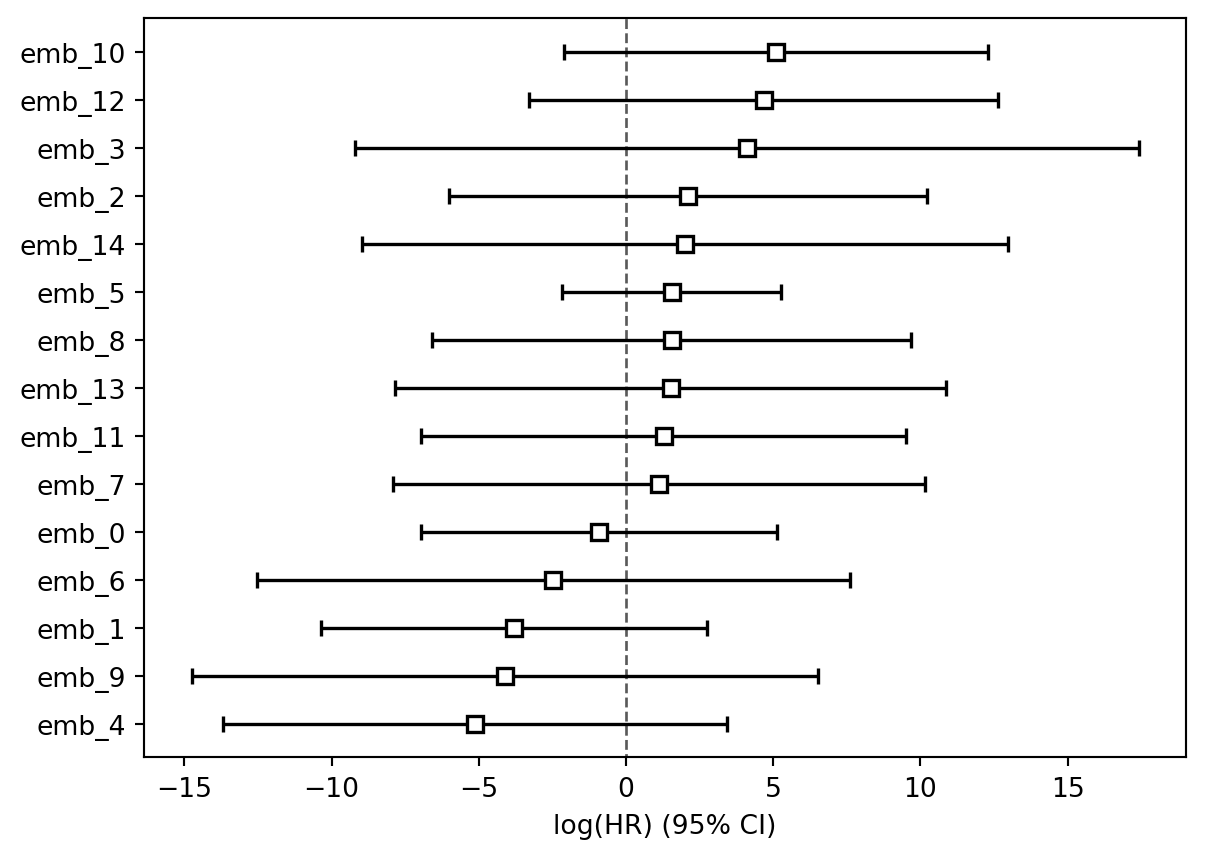

In [18]:
cph.plot()

None of these look like very good predictors...

----------------

## New Survival Times

Predict median life remaining for censored subjects:

In [19]:
censor_idx = emb[~emb.Status].index

censored_subjects = emb.loc[censor_idx]
censored_subjects_last_obs = censored_subjects["Months"]

In [20]:
med_life_remain = cph.predict_median(censored_subjects, censored_subjects_last_obs)

new_eol = emb.loc[censor_idx]["Months"] + med_life_remain
new_eol.name = "Months"

Prediced end of life for censored subjects:

<Axes: xlabel='Months', ylabel='Count'>

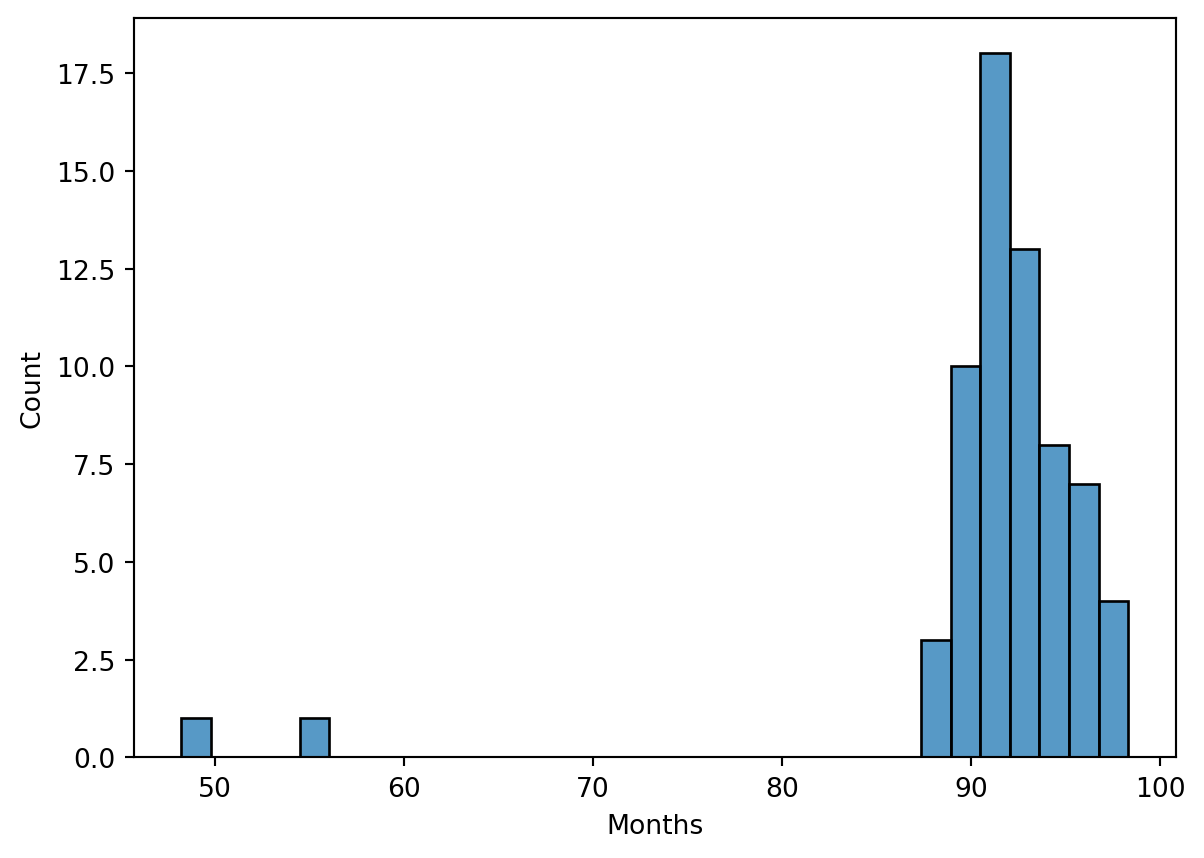

In [21]:
sns.histplot(new_eol)

Every censored sample gets lots of extra life (good for them). 

Compare to observed deaths and time at censor:

<Axes: xlabel='Months', ylabel='Count'>

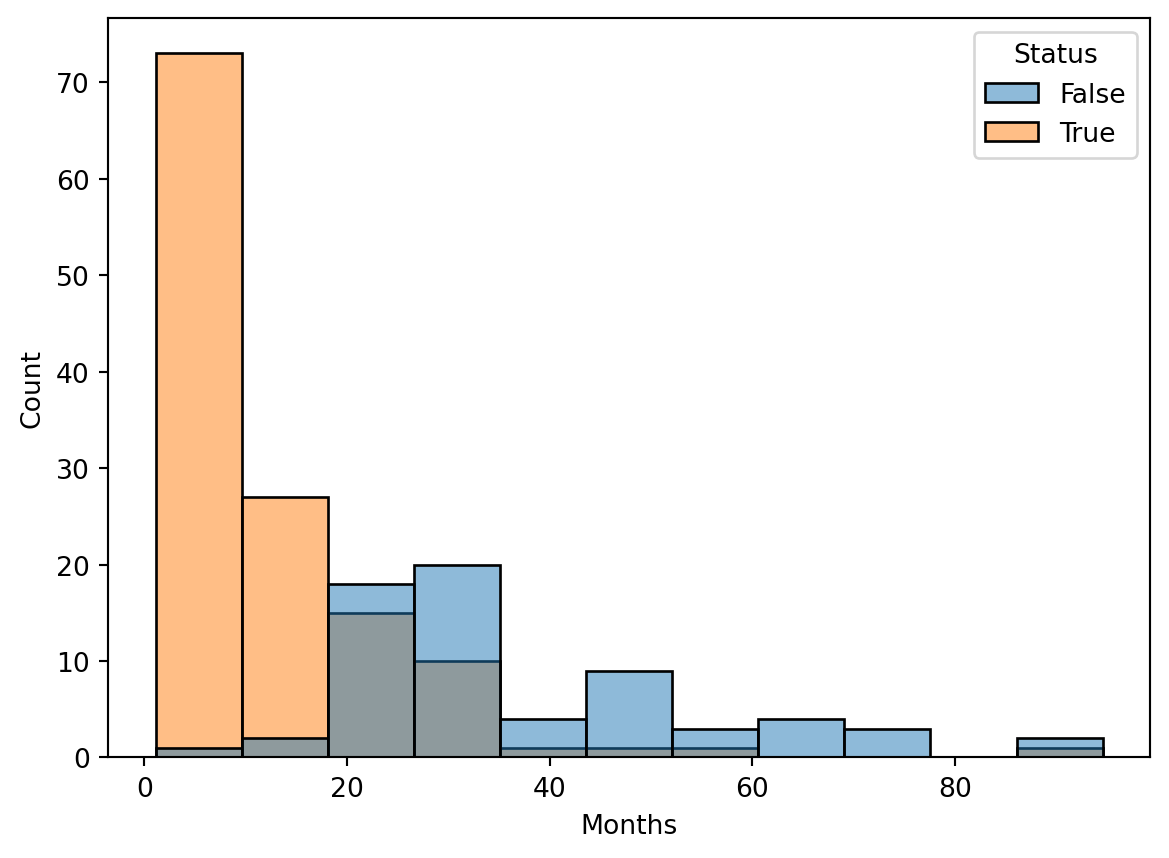

In [22]:
sns.histplot(emb, x="Months", hue="Status")

In [23]:
pred_eol_emb = emb.copy()
pred_eol_emb.update(new_eol)

<Axes: xlabel='Months', ylabel='Count'>

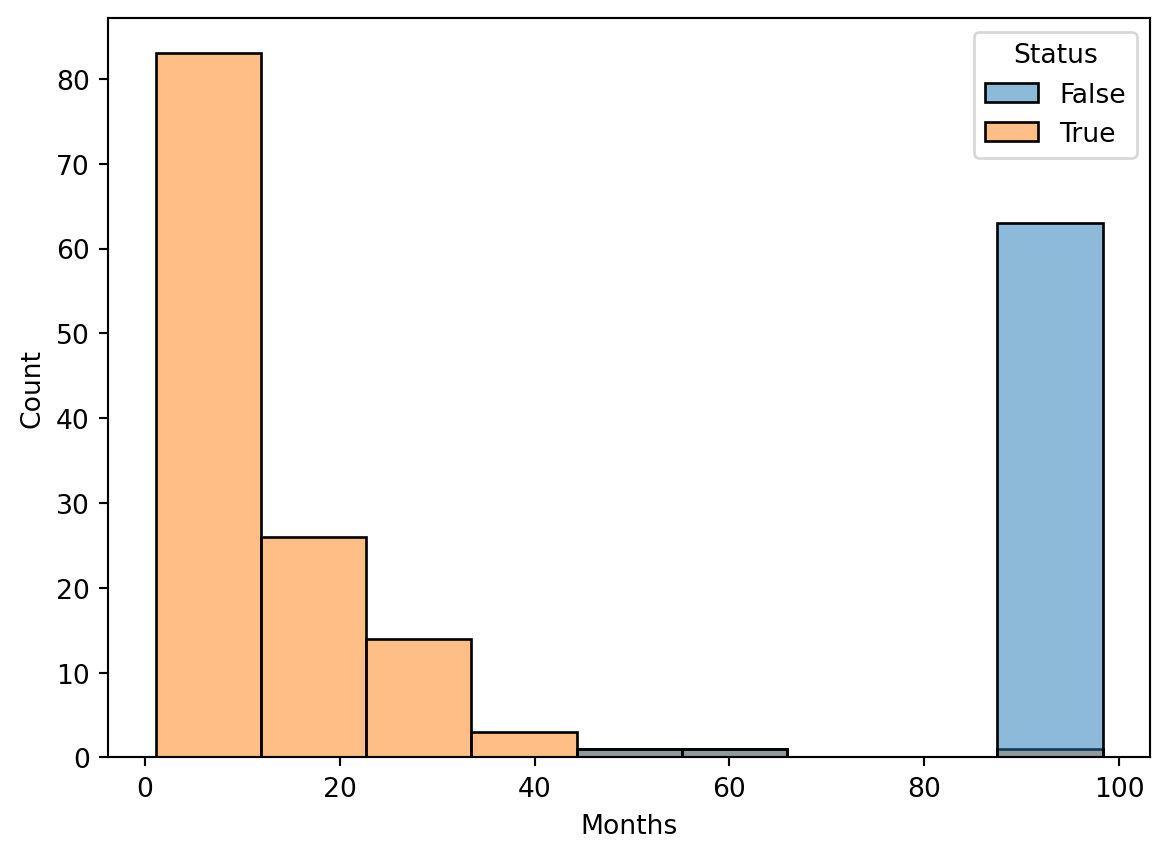

In [24]:
sns.histplot(pred_eol_emb, x="Months", hue="Status")

Annnnnd.... the dataset is now dramatically split by censored/uncensored subjects! Let's move ahead and model it.

I'd say a 5 year survival time is great! Let's use that as the new binary cutoff for 'poor' vs 'good' prognosis, and train a predictive model.

##  Random Forest Classifier

In [25]:
y = pred_eol_emb.Months >= 60
X = pred_eol_emb.drop(["Months", "Status"], axis=1).values

In [26]:
clf = RandomForestClassifier(n_estimators=200, random_state=seed)

cv = StratifiedKFold(n_splits=10)
scores = cross_validate(
    clf, X, y, cv=cv, scoring=("accuracy", "f1_micro"), return_train_score=True
)

print(
    f"""Mean Test Accuracy: {scores['test_accuracy'].mean()}
Mean Test F1: {scores['test_f1_micro'].mean()}"""
)

Mean Test Accuracy: 0.6265789473684211
Mean Test F1: 0.6265789473684211


Honestly those mean cross-val test scores aren't too shabby (don't know why the accuracy and f1 are identical though..), considering we started off with such sparse and sketchy data. Imagine if one really could predict >= 5 year survival time based solely on on HLA types and 9-mer peptide sequences...

That indicates there was a decent bit of data leakage in the pre-processing. That or I'm simply not accounting for 'batch' effects of each dataset. Seems the survival regression is heavily favoring censored subjects... which is carrying through here. 

The feature space is certainly large and noisy enough to get great training accuracy:

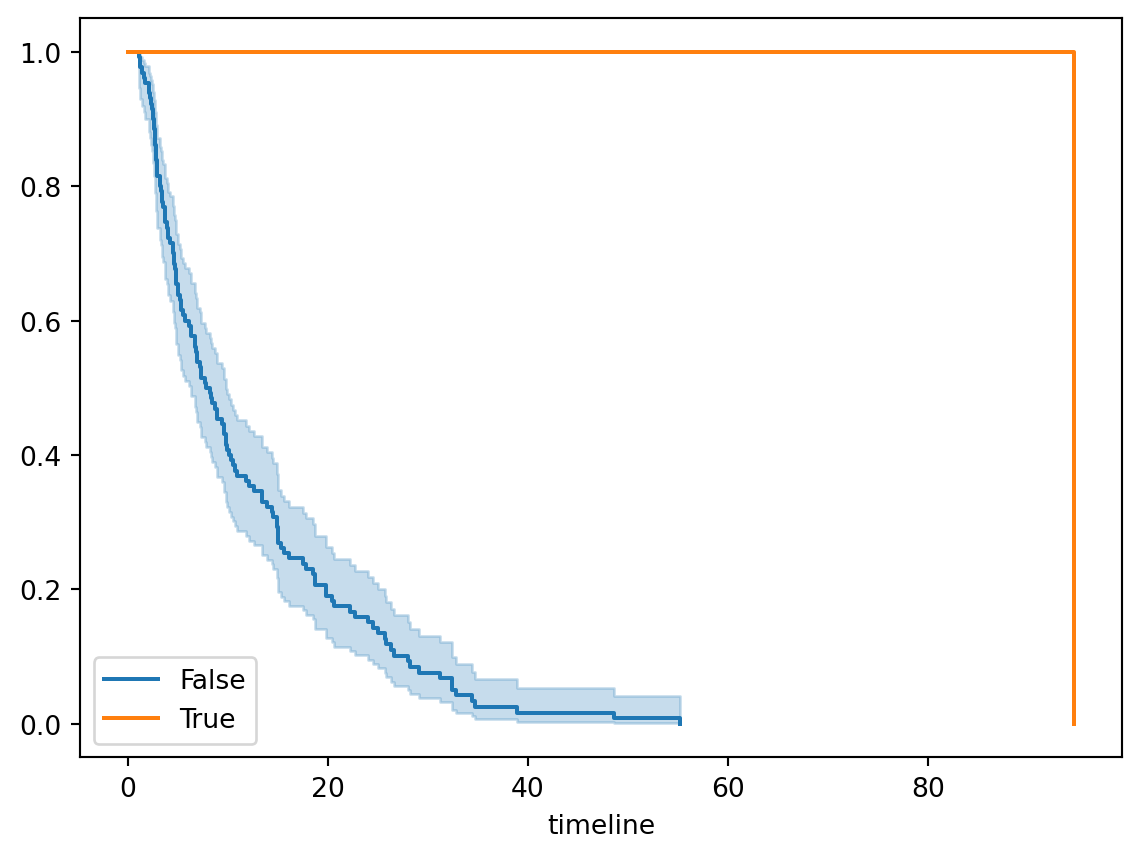

In [27]:
clf.fit(X, y)

y_pred = clf.predict(X)

df_pred_surv = df_surv.loc[y.index]
df_pred_surv["good_prognosis"] = y_pred
good_idx = df_pred_surv.good_prognosis

ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in df_pred_surv.groupby("good_prognosis"):
    kmf.fit(grouped_df["Months"], grouped_df["Status"], label=name)
    kmf.plot_survival_function(
        ax=ax,
    )

In [28]:
logrank_test(
    df_pred_surv.Months[good_idx],
    df_pred_surv.Months[~good_idx],
    df_pred_surv.Status[good_idx],
    df_pred_surv.Status[~good_idx],
)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         162.20 <0.005    121.01

We did it!!! Problem solved!

--------------------------------

It'll fall apart with any sort of cross-validation. Here's a simple manual bootstrap for lack of time.

For each iter:

1. Split the dataset into train/test sets.
  
2. Predict 'good' response using the random forest classifier

3. Group test set into predicted good vs poor prognosis sets

4. Get p-value by log-rank test

In [29]:
p_values = []

for i in range(0, 100):
    (eol_train, eol_test) = train_test_split(pred_eol_emb, test_size=0.50)

    y_train = eol_train.Months >= 60
    y_test = eol_test.Months >= 60

    X_train = eol_train.drop(["Months", "Status"], axis=1).values
    X_test = eol_test.drop(["Months", "Status"], axis=1).values

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    df_pred_surv = df_surv.loc[y_test.index]
    df_pred_surv["good_prognosis"] = y_pred

    good_idx = df_pred_surv.good_prognosis

    p_values.append(
        logrank_test(
            df_pred_surv.Months[good_idx],
            df_pred_surv.Months[~good_idx],
            df_pred_surv.Status[good_idx],
            df_pred_surv.Status[~good_idx],
        ).p_value
    )

In [30]:
np.min(p_values)

0.011950965003519557

<Axes: ylabel='Count'>

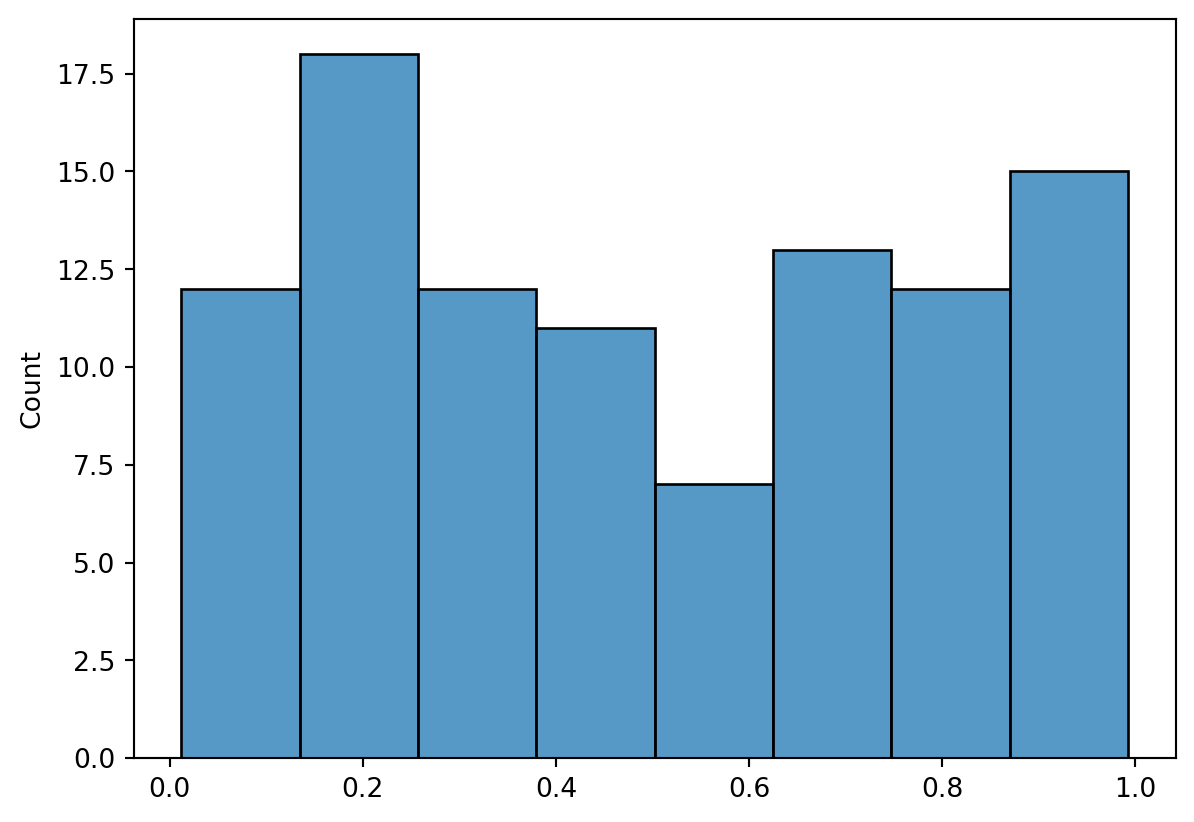

In [31]:
sns.histplot(p_values)

Suddenly things don't look too great. Example curve from the test set predictions: 

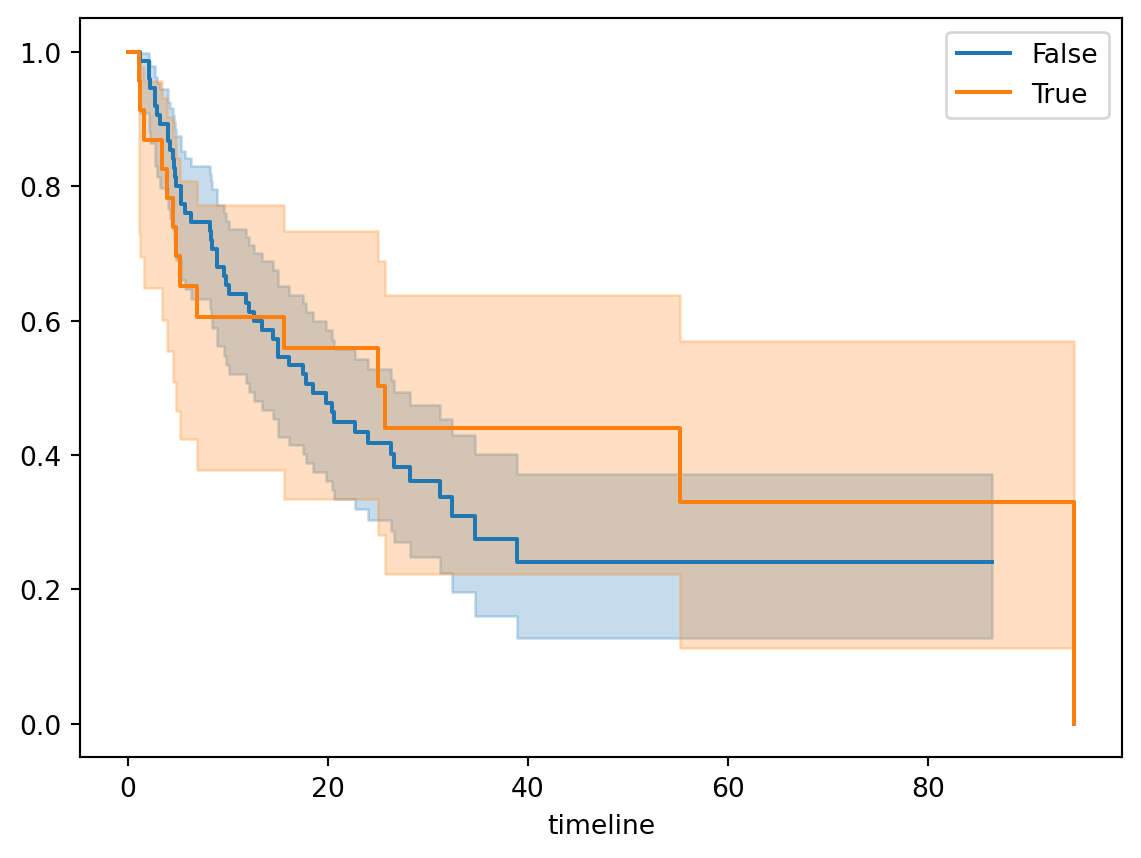

In [32]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in df_pred_surv.groupby("good_prognosis"):
    kmf.fit(grouped_df["Months"], grouped_df["Status"], label=name)
    kmf.plot_survival_function(
        ax=ax,
    )